In [2]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator
from hazma.vector_mediator import VectorMediator
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import (energy_res_fermi,
                                                               energy_res_e_astrogam,
                                                               A_eff_e_astrogam,
                                                               A_eff_comptel,
                                                               egret_diffuse,
                                                               fermi_diffuse,
                                                               comptel_diffuse,
                                                               gc_target,
                                                               gc_bg_model)
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.cmb import vx_cmb

colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load relic density curve

In [3]:
rd_mxs, rd_lims = np.loadtxt("relic_abundance.dat", delimiter=",").T
rd_mxs = 1e3*10.**rd_mxs  # convert GeV -> MeV
rd_lims = 10.**rd_lims

# Scalar mediator

## Setup

In [3]:
s_theta = 0.5
sm_hp = ScalarMediator(mx=1., ms=1000., gsxx=1.0, gsff=s_theta, gsGG=s_theta, gsFF=-s_theta)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100  # 100
sm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [4]:
sm_lims_e_astrogam = sm_hp.unbinned_limits(sm_mxs, target_params=gc_target, bg_model=gc_bg_model, A_eff=A_eff_e_astrogam)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:100: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:102: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1./np.sqrt(I_B_val) * \
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:106: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val/np.sqrt(I_B_val), jac_val
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [5]:
sm_lims_egret = sm_hp.binned_limits(sm_mxs, egret_diffuse)
sm_lims_comptel = sm_hp.binned_limits(sm_mxs, comptel_diffuse)
sm_lims_fermi = sm_hp.binned_limits(sm_mxs, fermi_diffuse)

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [6]:
# sm_lims_cmb = sm_hp.cmb_limits(sm_mxs)

### Save results

In [7]:
np.savetxt("data/sm_lims_egret.csv",
           np.array([sm_mxs, sm_lims_egret]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_comptel.csv",
           np.array([sm_mxs, sm_lims_comptel]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
np.savetxt("data/sm_lims_fermi.csv",
           np.array([sm_mxs, sm_lims_fermi]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

np.savetxt("data/sm_lims_e_astrogam.csv",
           np.array([sm_mxs, sm_lims_e_astrogam]).T,
           delimiter=",",
           header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/sm_lims_cmb.csv",
#            np.array([sm_mxs, sm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [8]:
# sm_mxs, sm_lims_egret = np.loadtxt("data/sm_lims_egret.csv", delimiter=",").T
# sm_mxs, sm_lims_comptel = np.loadtxt("data/sm_lims_comptel.csv", delimiter=",").T
# sm_mxs, sm_lims_fermi = np.loadtxt("data/sm_lims_fermi.csv", delimiter=",").T
# sm_mxs, sm_lims_e_astrogam = np.loadtxt("data/sm_lims_e_astrogam.csv", delimiter=",").T
sm_mxs, sm_lims_cmb = np.loadtxt("data/sm_lims_cmb.csv", delimiter=",").T

## Plot results

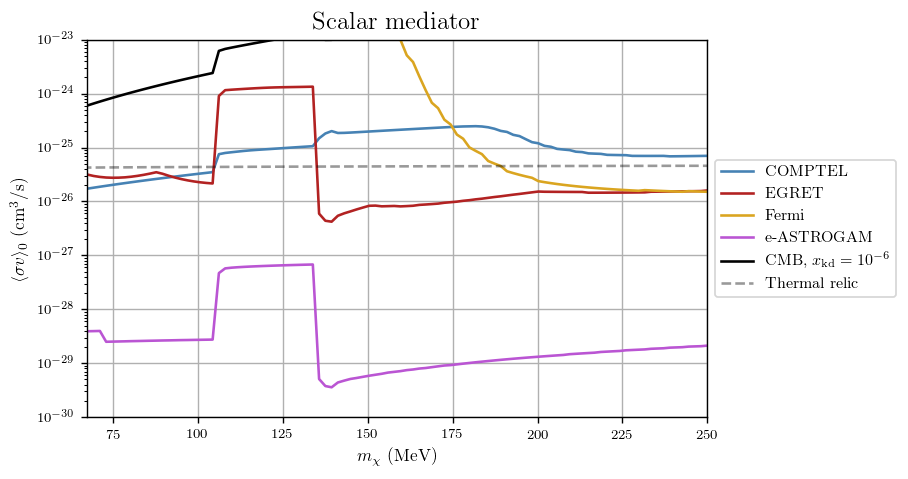

In [23]:
plt.figure(figsize=(8, 4))

plt.plot(sm_mxs, sm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(sm_mxs, sm_lims_egret, label="EGRET", color=colors[1])
plt.plot(sm_mxs, sm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(sm_mxs, sm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-6))**2 * sm_lims_cmb, label=r"CMB, $x_{\mathrm{kd}} = 10^{-6}$", color="black")
# plt.plot(sm_mxs, (1.0e-3 / vx_cmb(sm_mxs, x_kd=1e-4))**2 * sm_lims_cmb, label=r"CMB, $x_{\mathrm{kd}} = 10^{-4}$", color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(sm_mxs[[0, -1]])
plt.ylim([1e-30,1e-23])
# plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")  #  * (v_\chi / v_0)^2
plt.title("Scalar mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("figures/sm_sigmav_limits.pdf")

In [10]:
import os
os.system('say "Done computing limits"')

0

# Vector mediator

## Setup

In [4]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 100
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

## Recompute constraints

In [12]:
vm_lims_comptel = vm.binned_limits(vm_mxs, comptel_diffuse)
vm_lims_egret = vm.binned_limits(vm_mxs, egret_diffuse)
vm_lims_fermi = vm.binned_limits(vm_mxs, fermi_diffuse)

In [13]:
vm_lims_e_astrogam = vm.unbinned_limits(vm_mxs, target_params=gc_target, bg_model=gc_bg_model)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/gamma_ray_limits/compute_limits.py:202: RuntimeWarning: divide by zero encountered in double_scalars
  lim = prefactor * n_sigma / (-limit_obj.fun)


In [14]:
# vm_lims_cmb = vm.cmb_limits(vm_mxs)

In [15]:
# np.savetxt("data/vm_lims_comptel.csv",
#            np.array([vm_mxs, vm_lims_comptel]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_egret.csv",
#            np.array([vm_mxs, vm_lims_egret]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_fermi.csv",
#            np.array([vm_mxs, vm_lims_fermi]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")
# np.savetxt("data/vm_lims_e_astrogam.csv",
#            np.array([vm_mxs, vm_lims_e_astrogam]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

# np.savetxt("data/vm_lims_cmb.csv",
#            np.array([vm_mxs, vm_lims_cmb]).T,
#            delimiter=",",
#            header="Columns: mx (MeV), <sigma v> limit (cm^3/s)")

## Load previously computed constraints

In [5]:
vm_mxs, vm_lims_egret = np.loadtxt("data/vm_lims_egret.csv", delimiter=",").T
vm_mxs, vm_lims_comptel = np.loadtxt("data/vm_lims_comptel.csv", delimiter=",").T
vm_mxs, vm_lims_fermi = np.loadtxt("data/vm_lims_fermi.csv", delimiter=",").T
vm_mxs, vm_lims_e_astrogam = np.loadtxt("data/vm_lims_e_astrogam.csv", delimiter=",").T
vm_mxs, vm_lims_cmb = np.loadtxt("data/vm_lims_cmb.csv", delimiter=",").T

## Plot results

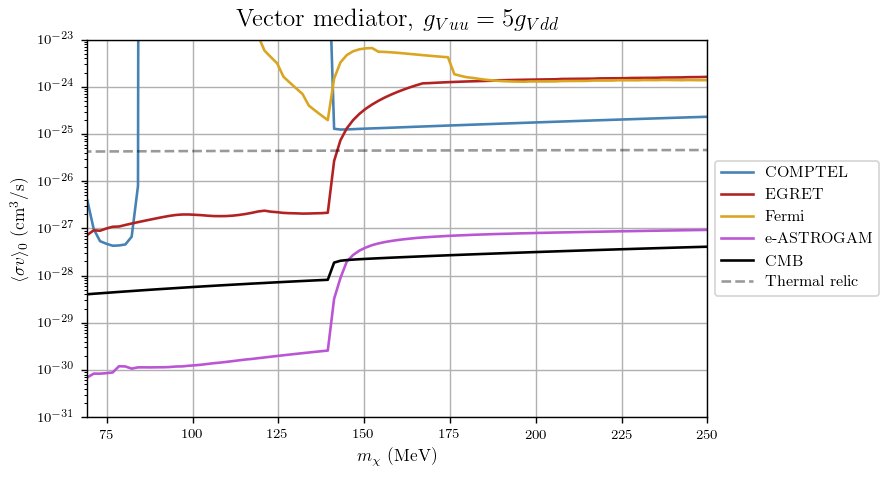

In [7]:
plt.figure(figsize=(8, 4))

plt.plot(vm_mxs, vm_lims_comptel, label="COMPTEL", color=colors[0])
plt.plot(vm_mxs, vm_lims_egret, label="EGRET", color=colors[1])
plt.plot(vm_mxs, vm_lims_fermi, label="Fermi", color=colors[2])
plt.plot(vm_mxs, vm_lims_e_astrogam, label="e-ASTROGAM", color=colors[3])
plt.plot(vm_mxs, vm_lims_cmb, label="CMB", color="black")
plt.plot(rd_mxs, rd_lims, '--', label="Thermal relic", color="black", alpha=0.4)

plt.xlim(vm_mxs[[1, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle_0$ (cm$^3$/s)")
plt.title(r"Vector mediator, $g_{Vuu} = %i g_{Vdd}$" % (vm.gvuu/vm.gvdd))

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig("figures/vm_sigmav_limits.pdf")

In [18]:
import os
os.system('say "Done computing limits"')

0

## Scratch: checking detected spectrum

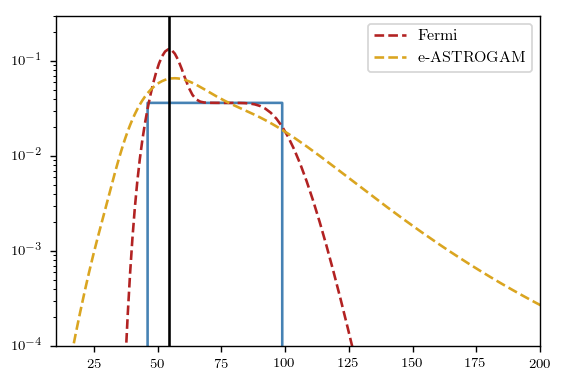

In [11]:
e_gam_min, e_gam_max, n_e_gams = 10, 1000., 200
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

vm = VectorMediator(mx=100., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)
e_cm = 2.*vm.mx*(1+0.5*1e-6)

dndes_det_fermi = get_detected_spectrum(lambda es, e_cm: vm.spectra(es, e_cm)["total"],
                                        vm.gamma_ray_lines,
                                        10, 1000, e_cm, energy_res_fermi)

dndes_det_e_a = get_detected_spectrum(lambda es, e_cm: vm.spectra(es, e_cm)["total"],
                                      vm.gamma_ray_lines,
                                      10, 1000, e_cm, energy_res_e_astrogam)

plt.plot(e_gams, vm.spectra(e_gams, e_cm)["total"])
plt.plot(e_gams, dndes_det_fermi(e_gams), '--', label="Fermi")
plt.plot(e_gams, dndes_det_e_a(e_gams), '--', label="e-ASTROGAM")
plt.axvline(vm.gamma_ray_lines(e_cm)["pi0 g"]["energy"], color='k')

plt.xlim(10, 200)
plt.ylim(1e-4, 3e-1)
plt.legend()
plt.yscale("log")

## Look out how constraints vary with couplings

In [39]:
vm = VectorMediator(mx=1., mv=1000., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# Masses to scan over
mx_min, mx_max, n_mxs = mpi0/2., 250., 30
vm_mxs = np.linspace(mx_min, mx_max, n_mxs)

# Couplings to scan over
# gvdds = np.linspace(-0.5, 1.5, 5)
gvdds = np.array([-0.5, 0.9, 1., 2.])

In [44]:
# Compute EGRET limits for the different couplings
# vm_lims_egret_gvdd = []

for gvdd in gvdds[2:]:
    print "gvdd = %f" % gvdd
    vm.gvdd = gvdd
    vm_lims_egret_gvdd.append(vm.binned_limits(mxs, egret_diffuse))

gvdd = 1.000000
gvdd = 2.000000


In [45]:
# Set up the colormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=gvdds[0], vmax=gvdds[-1])
m = cm.ScalarMappable(norm=norm, cmap=cmap)

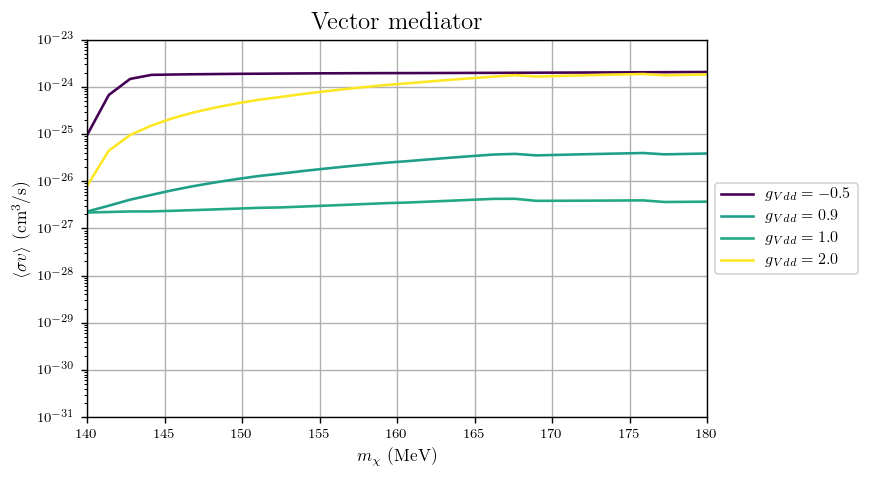

In [48]:
plt.figure(figsize=(8, 4))

for gvdd, lims in zip(gvdds, vm_lims_egret_gvdd):
    plt.plot(mxs, lims, label=r"$g_{Vdd}=%.1f$" % gvdd,
             color=m.to_rgba(gvdd))

# Formatting
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-31,1e-23])
plt.xscale("linear")
plt.yscale("log")
plt.grid()
plt.xlabel(r"$m_\chi$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Vector mediator")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Scratch/testing

(1e-10, 1.0)

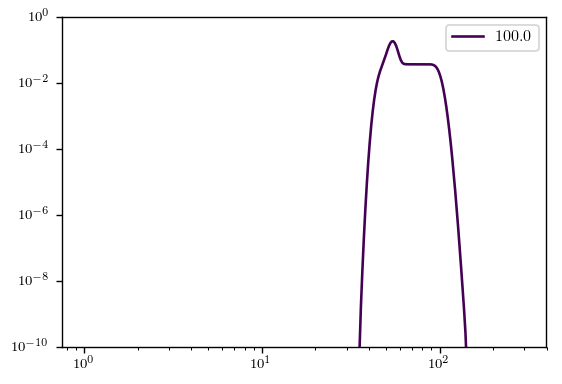

In [23]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel
import matplotlib.cm as cm
from matplotlib.colors import Normalize

vm = VectorMediator(mx=1., mv=201., gvxx=1., gvuu=1., gvdd=0.2, gvss=0., gvee=0., gvmumu=0.)

# mx_min, mx_max, n_mxs = 70, 200., 4
# mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
mxs = np.array([100.])

cmap = cm.viridis
norm = Normalize(vmin=np.log10(mxs[0]), vmax=np.log10(mxs[-1]))

e_gams = np.logspace(0, np.log10(300), 300)

for mx in mxs:
    vm.mx = mx
    e_cm = 2.*vm.mx*(1.+0.5*1e-6)

    dnde_det = get_detected_spectrum(e_gams, vm.spectra(e_gams, e_cm)["total"], *vm.gamma_ray_lines(e_cm), energy_res=energy_res_comptel)
    
    plt.loglog(e_gams, dnde_det(e_gams), color=cmap(norm(np.log10(mx))), label="%.1f" % mx)
    
plt.legend()
plt.ylim(1e-10, 1e0)

In [30]:
for fm in [comptel_diffuse, egret_diffuse, fermi_diffuse]:
    print fm.bins[0][0], fm.bins[-1][-1]

0.7703084693028202 27.618455799248043
27.618455799248043 8626.25729321894
153.2191922762135 94968.96255955588


In [17]:
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

mx = 200.
vm.mx = mx
e_cm = 2.*vm.mx * (1. + 0.5*1e-6)

e_gams = np.logspace(np.log10(A_eff_e_astrogam.x[0])-1,
                     np.log10(A_eff_e_astrogam.x[-1])+1, 75)
dndes = vm.spectra(e_gams, e_cm)["total"]

dnde_det = get_detected_spectrum(e_gams, dndes, *vm.gamma_ray_lines(e_cm), energy_res=energy_res_e_astrogam)

In [18]:
e_min = max(A_eff_e_astrogam.x[0],
            dnde_det.x[np.where(dnde_det.y)[0][0]])
e_max = min(A_eff_e_astrogam.x[-1],
            dnde_det.x[np.where(dnde_det.y)[0][-1]])
e_dnde_max = dnde_det.x[np.argmax(dnde_det.y)]
print(e_min, e_max, e_dnde_max)

e_a_0 = 10.**(0.5 * (np.log10(e_dnde_max) + np.log10(e_min)))
e_b_0 = 10.**(0.5 * (np.log10(e_max) + np.log10(e_dnde_max)))

(0.3, 3000.0, 0.03615782810612527)


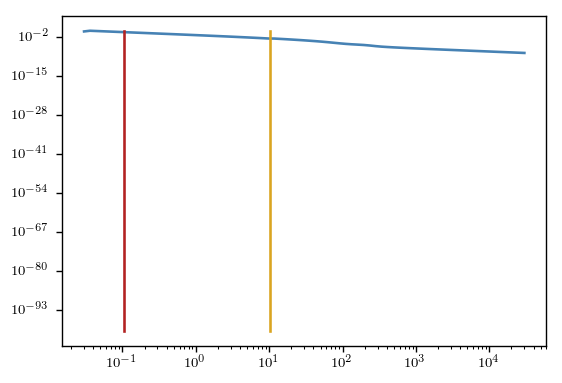

In [19]:
plt.loglog(e_gams, dnde_det(e_gams))
plt.loglog(2*[e_a_0], [1e-100, 1e0])
plt.loglog(2*[e_b_0], [1e-100, 1e0])